<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/DefaultPredictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Predictors
Predictors used:
* Gradient Booster
* Neural Network
* LSTM
* Transformer

In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 723.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 490.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


## Fetching Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

In [3]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git


Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 7), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (37/37), 30.19 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [5]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [6]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [7]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [8]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286221,1.367432,15_9-F-11A,2600.4


## Outlier Removal

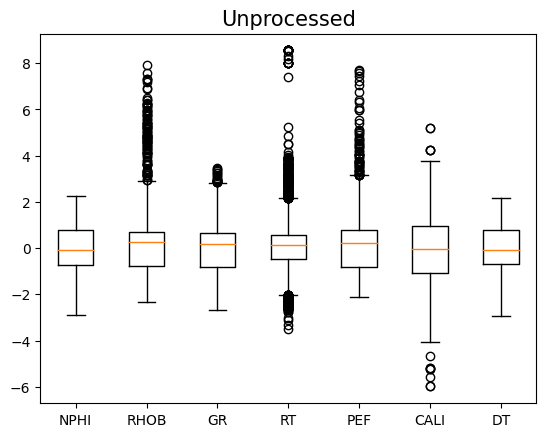

n samples unprocessed: 24403


In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

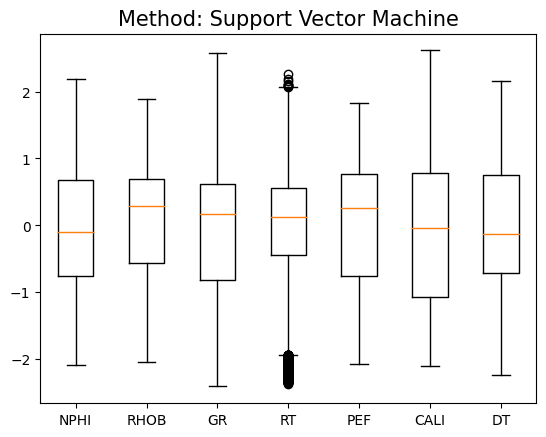

Remaining samples: 21964


In [10]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Method: Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [11]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [12]:
import pandas as pd

# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val



In [13]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

### Decison Tree Regressor


In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

# Fit the regressor to the training data
model_decision_tree.fit(X_train, y_train)

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


R2 Log 1: 0.9822
RMSE Log 1: 0.1435
R2 Log 3: 0.9825
RMSE Log 3: 0.1224
R2 Log 4: 0.9417
RMSE Log 4: 0.184


### Gradient Booster Regressor

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

# Fit the regressor to the training data
model_grad_boost.fit(X_train, y_train)

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Log 1: 0.9527
RMSE Log 1: 0.2335
R2 Log 3: 0.9429
RMSE Log 3: 0.221
R2 Log 4: 0.8959
RMSE Log 4: 0.2458


### Neural Network

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [18]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Fit the neural network model to the training data
history_nn = model_nn.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_val1, y_val1))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


Epoch 1/32
687/687 [==============================] - 6s 7ms/step - loss: 0.0531 - val_loss: 0.0828
Epoch 2/32
687/687 [==============================] - 2s 3ms/step - loss: 0.0401 - val_loss: 0.0683
Epoch 3/32
687/687 [==============================] - 2s 3ms/step - loss: 0.0385 - val_loss: 0.0625
Epoch 4/32
687/687 [==============================] - 2s 3ms/step - loss: 0.0376 - val_loss: 0.0559
Epoch 5/32
687/687 [==============================] - 2s 2ms/step - loss: 0.0367 - val_loss: 0.0575
Epoch 6/32
687/687 [==============================] - 2s 2ms/step - loss: 0.0357 - val_loss: 0.0524
Epoch 7/32
687/687 [==============================] - 2s 3ms/step - loss: 0.0354 - val_loss: 0.0592
Epoch 8/32
687/687 [==============================] - 3s 4ms/step - loss: 0.0344 - val_loss: 0.0563
Epoch 9/32
687/687 [==============================] - 4s 6ms/step - loss: 0.0342 - val_loss: 0.0531
Epoch 10/32
687/687 [==============================] - 3s 5ms/step - loss: 0.0333 - val_loss: 0.0518

### LSTM

In [19]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam

In [20]:
X_train.shape

(21964, 6)

In [21]:
# # Define bidirectional LSTM model with three layers

# timesteps = 5

# model_lstm = Sequential()
# model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(timesteps, X_train.shape[1])))
# model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
# model_lstm.add(Bidirectional(LSTM(units=64)))
# model_lstm.add(Dense(units=1))  # Output layer
# model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# # Fit the LSTM model to the training data
# history = model_lstm.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val1, y_val1))

# # Validation: Predict on well 1
# y_pred1_lstm = model_lstm.predict(X_val1)
# rmse_lstm1 = np.sqrt(mean_squared_error(y_val1, y_pred1_lstm))
# print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# # Validation: Predict on well 3
# y_pred3_lstm = model_lstm.predict(X_val3)
# rmse_lstm3 = np.sqrt(mean_squared_error(y_val3, y_pred3_lstm))
# print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# # Validation: Predict on well 4
# y_pred4_lstm = model_lstm.predict(X_val4)
# rmse_lstm4 = np.sqrt(mean_squared_error(y_val4, y_pred4_lstm))
# print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


### Transformer

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [23]:
# # Define the Transformer model
# def transformer_model(input_shape):
#     inputs = Input(shape=input_shape)
#     transformer_layer = tfa.layers.TransformerEncoder(num_layers=2, d_model=64, num_heads=4,
#                                                       dff=256, input_vocab_size=input_shape[0],
#                                                       maximum_position_encoding=input_shape[1])
#     transformer_output = transformer_layer(inputs)
#     outputs = Dense(units=1)(transformer_output[:, -1, :])  # Take only the last output token
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# # Initialize and compile the Transformer model
# model_transformer = transformer_model(X_train.shape[1:])
# model_transformer.compile(optimizer='adam', loss='mean_squared_error')

# # Fit the Transformer model to the training data
# history_transformer = model_transformer.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val1, y_val1))

# # Validation: Predict on well 1
# y_pred1_transformer = model_transformer.predict(X_val1)
# rmse_transformer1 = np.sqrt(mean_squared_error(y_val1, y_pred1_transformer))
# print("RMSE Transformer Log 1: {}".format(round(rmse_transformer1, 4)))

# # Validation: Predict on well 3
# y_pred3_transformer = model_transformer.predict(X_val3)
# rmse_transformer3 = np.sqrt(mean_squared_error(y_val3, y_pred3_transformer))
# print("RMSE Transformer Log 3: {}".format(round(rmse_transformer3, 4)))

# # Validation: Predict on well 4
# y_pred4_transformer = model_transformer.predict(X_val4)
# rmse_transformer4 = np.sqrt(mean_squared_error(y_val4, y_pred4_transformer))
# print("RMSE Transformer Log 4: {}".format(round(rmse_transformer4, 4)))


### Formatting back the predictions

In [24]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   #y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    #y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

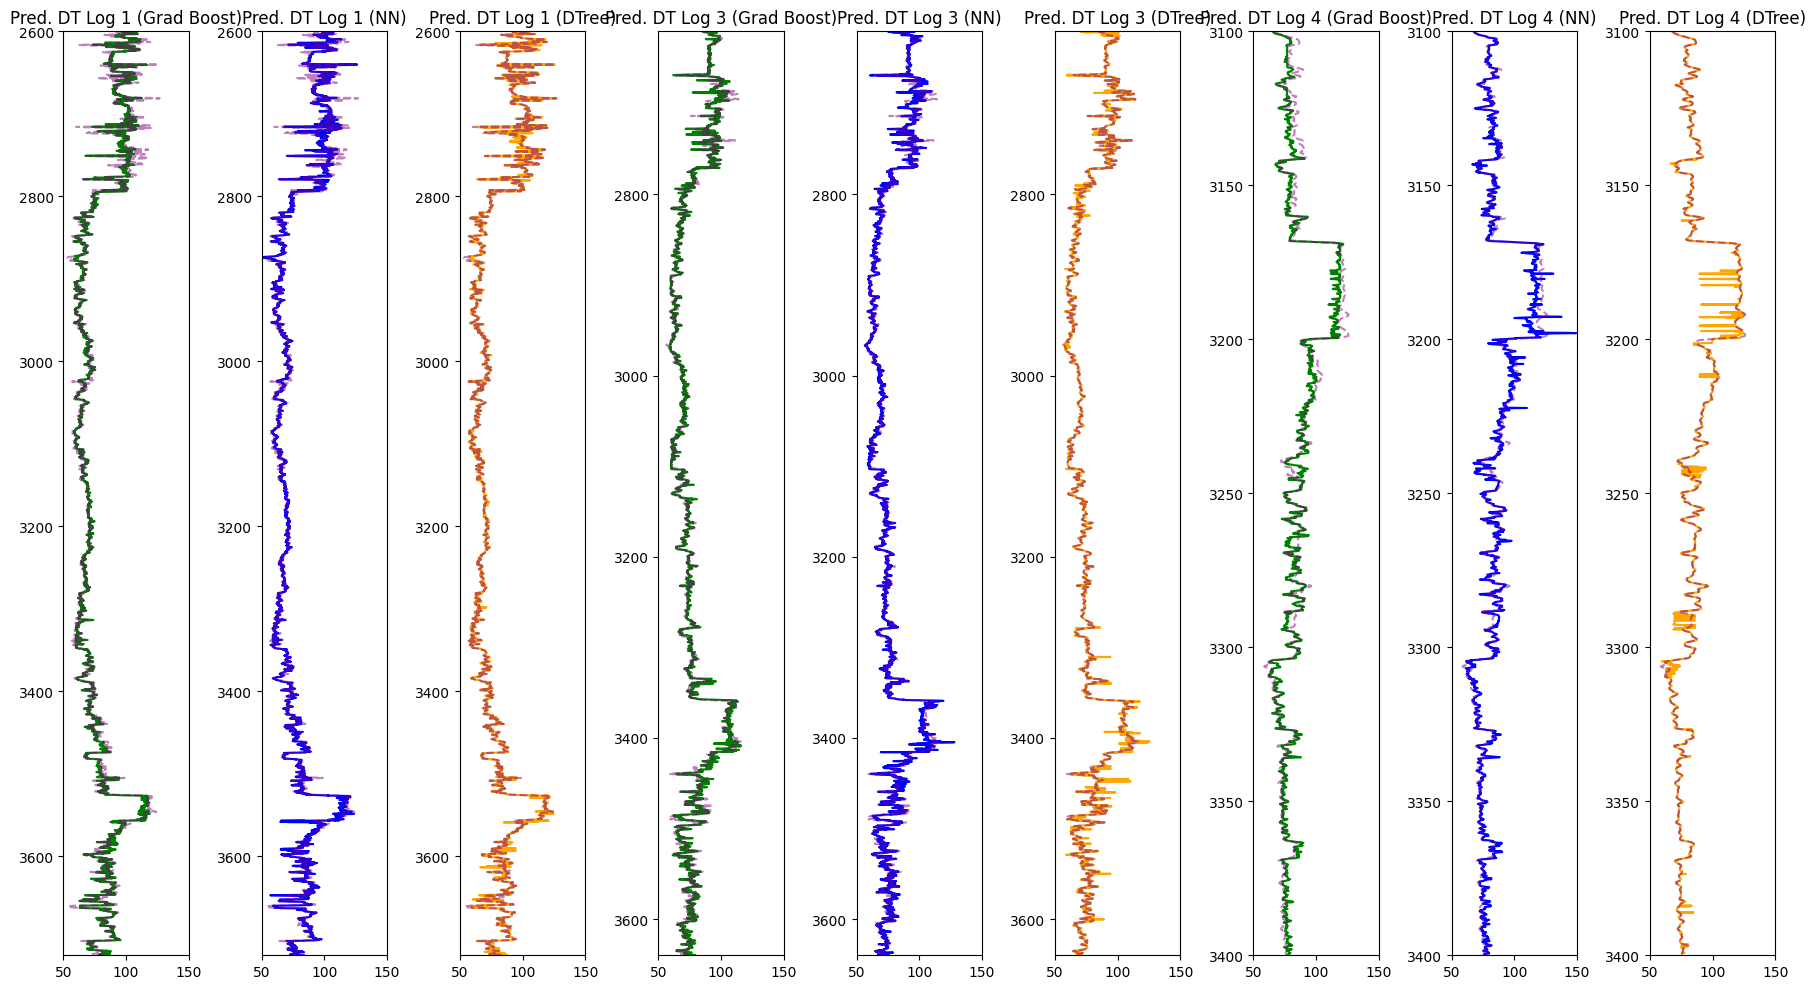

In [39]:
import matplotlib.pyplot as plt

x_plott = [y_pred1_grad_boost_inv, y_pred1_nn_inv, y_pred1_decision_tree_inv,
           y_pred3_grad_boost_inv, y_pred3_nn_inv, y_pred3_decision_tree_inv,
           y_pred4_grad_boost_inv, y_pred4_nn_inv, y_pred4_decision_tree_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

y_plott = [log1['DEPTH'], log1['DEPTH'], log1['DEPTH'],  log3['DEPTH'], log3['DEPTH'], log3['DEPTH'], log4['DEPTH'], log4['DEPTH'], log4['DEPTH']]

color_preds = ['green', 'blue',  'orange'] * 3
title_preds = ['Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)', 'Pred. DT Log 1 (DTree)',
               'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)', 'Pred. DT Log 3 (DTree)',
               'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)', 'Pred. DT Log 4 (DTree)']

fig, ax = plt.subplots(nrows=1, ncols=9, figsize=(18, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i]
    ax[i].plot(x_pred, y_i_reshaped, color=color_preds[i])
    ax[i].plot(x_real_plott[i//3], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5)
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [29]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [ ]:
X_test2

In [30]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
#y_pred2_lstm = model_lstm.predict(X_test2)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
#y_pred5_lstm = model_lstm.predict(X_test5)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
#y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
#y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 0s 1ms/step


In [31]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
#log2['DT_lstm'] = y_pred2_lstm
#log2['DT_transformer'] = y_pred2_transformer

# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
#log5['DT_lstm'] = y_pred5_lstm
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-31-844aa1dbc78f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-31-844aa1dbc78f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-31-844aa1dbc78f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

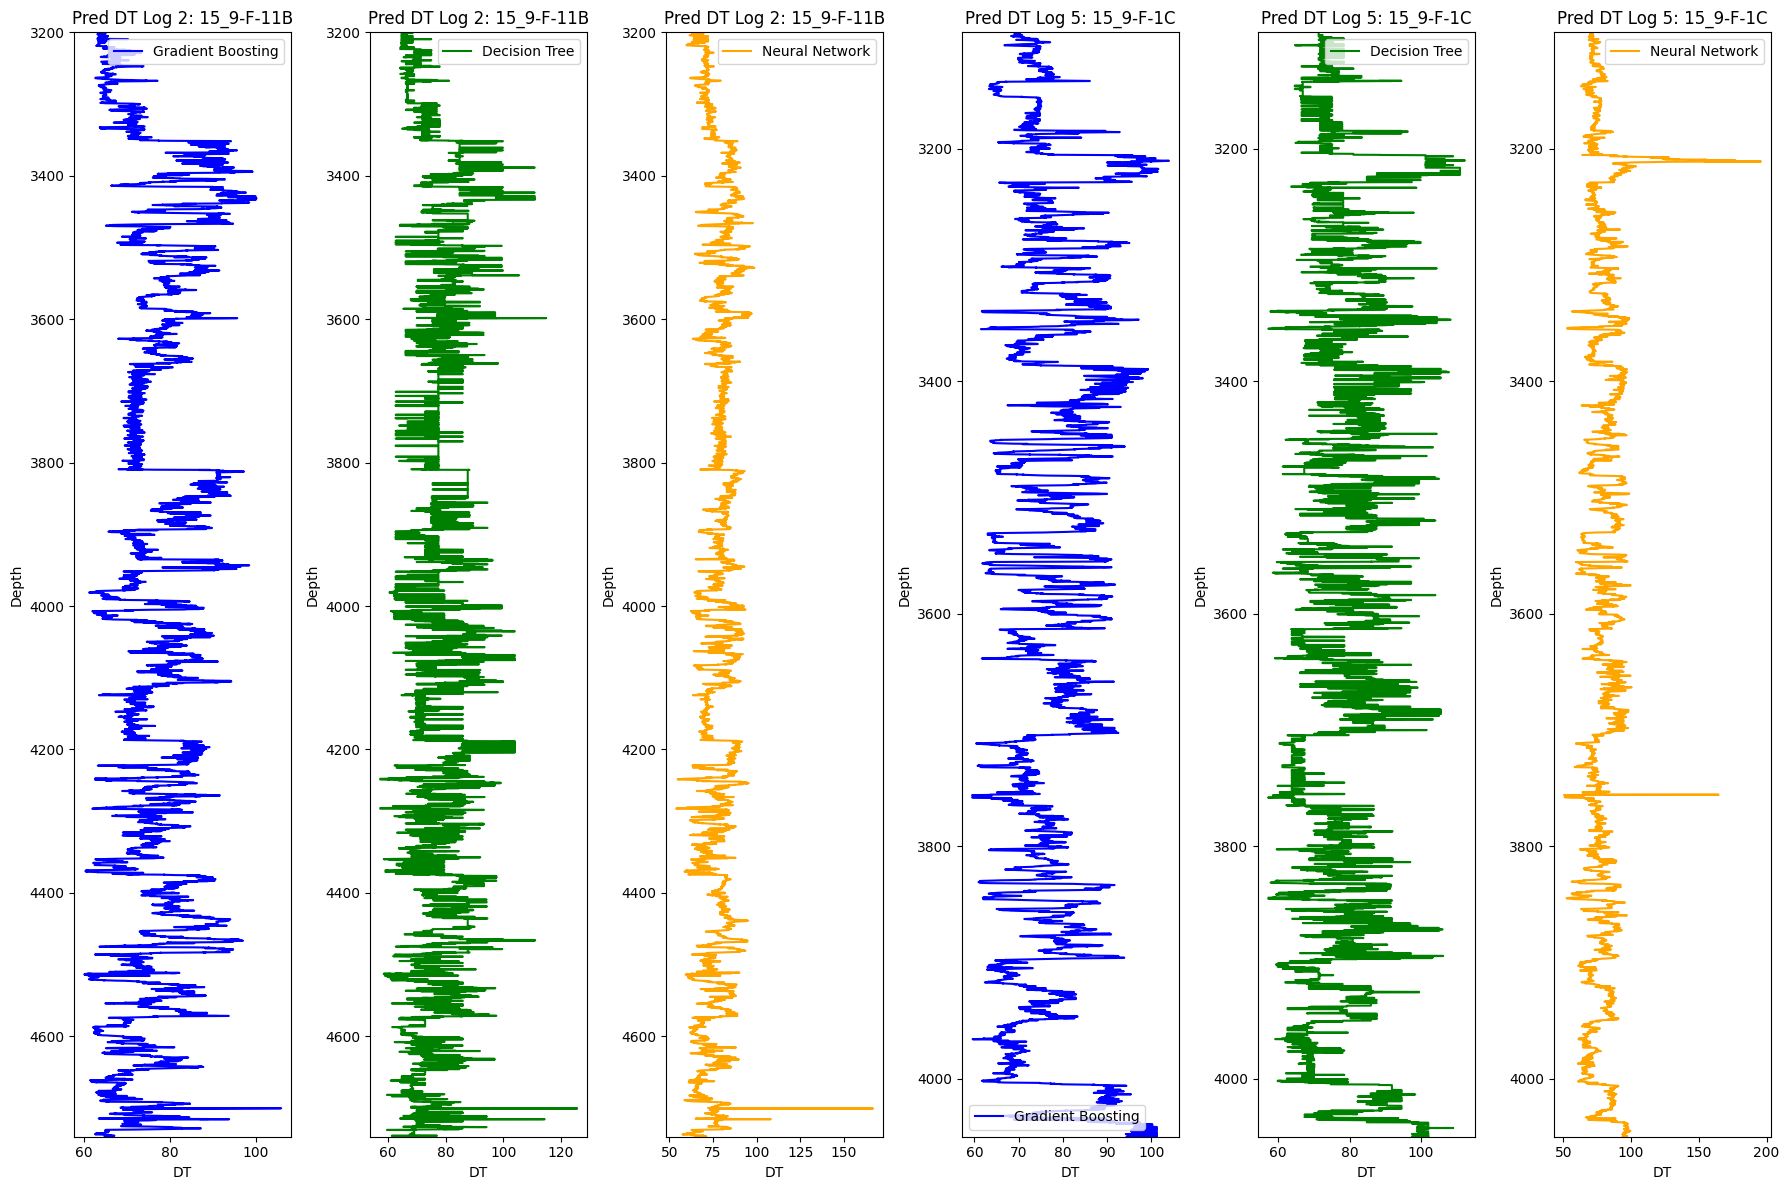

In [33]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2
plt.subplot(1, 6, 1)
plt.plot(y_pred2_grad_boost, depth2, color='blue', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 6, 2)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 6, 3)
plt.plot(y_pred2_nn, depth2, color='orange', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 6, 4)
plt.plot(y_pred5_grad_boost, depth5, color='blue', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 6, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 6, 6)
plt.plot(y_pred5_nn, depth5, color='orange', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [34]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_grad_boost', 'DT_Tree',  'DT_nn']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT GB', 'Predicted DT Decsion Tree', 'Predicted DT NN']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(15,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()






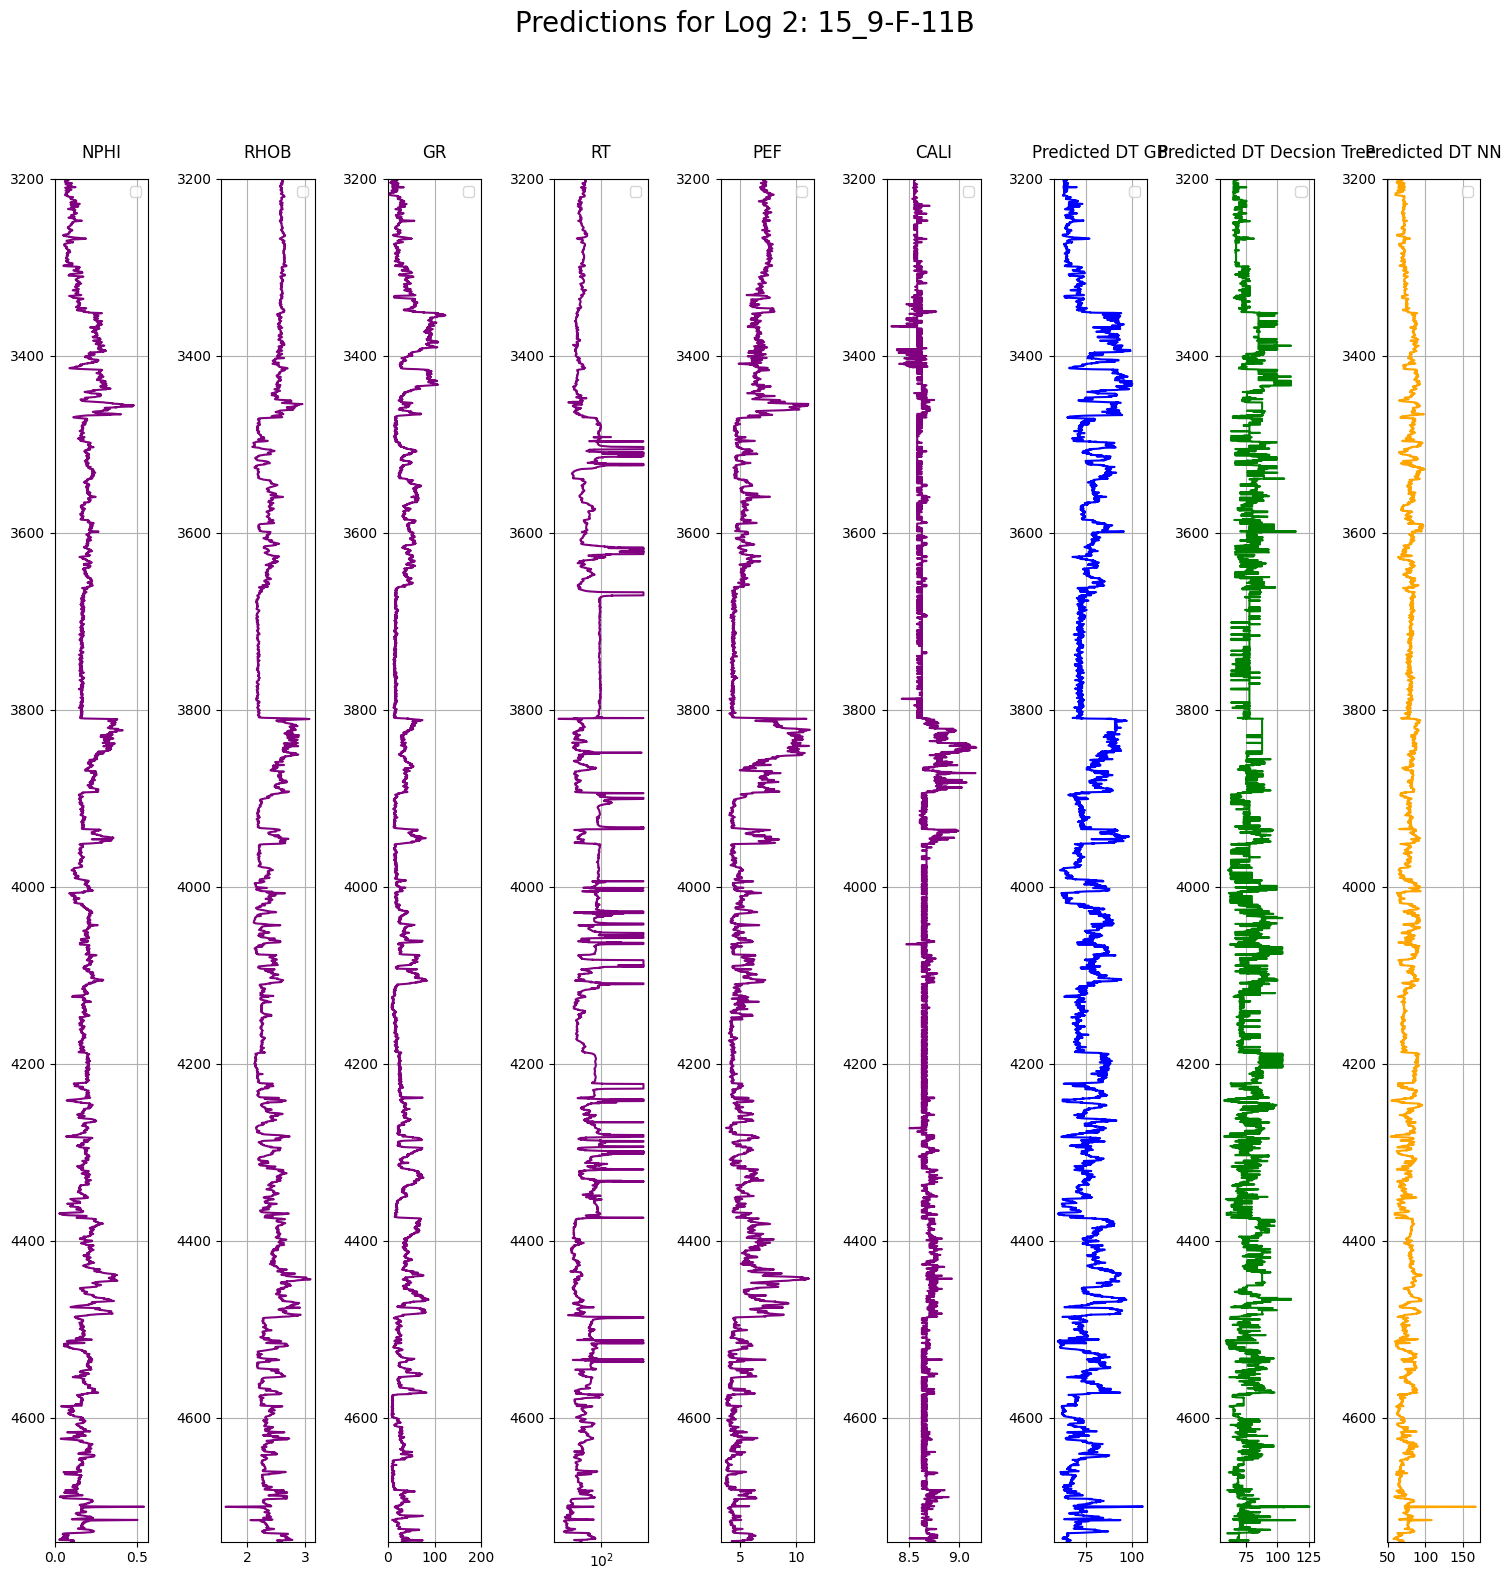

In [35]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue', 'green',  'orange'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

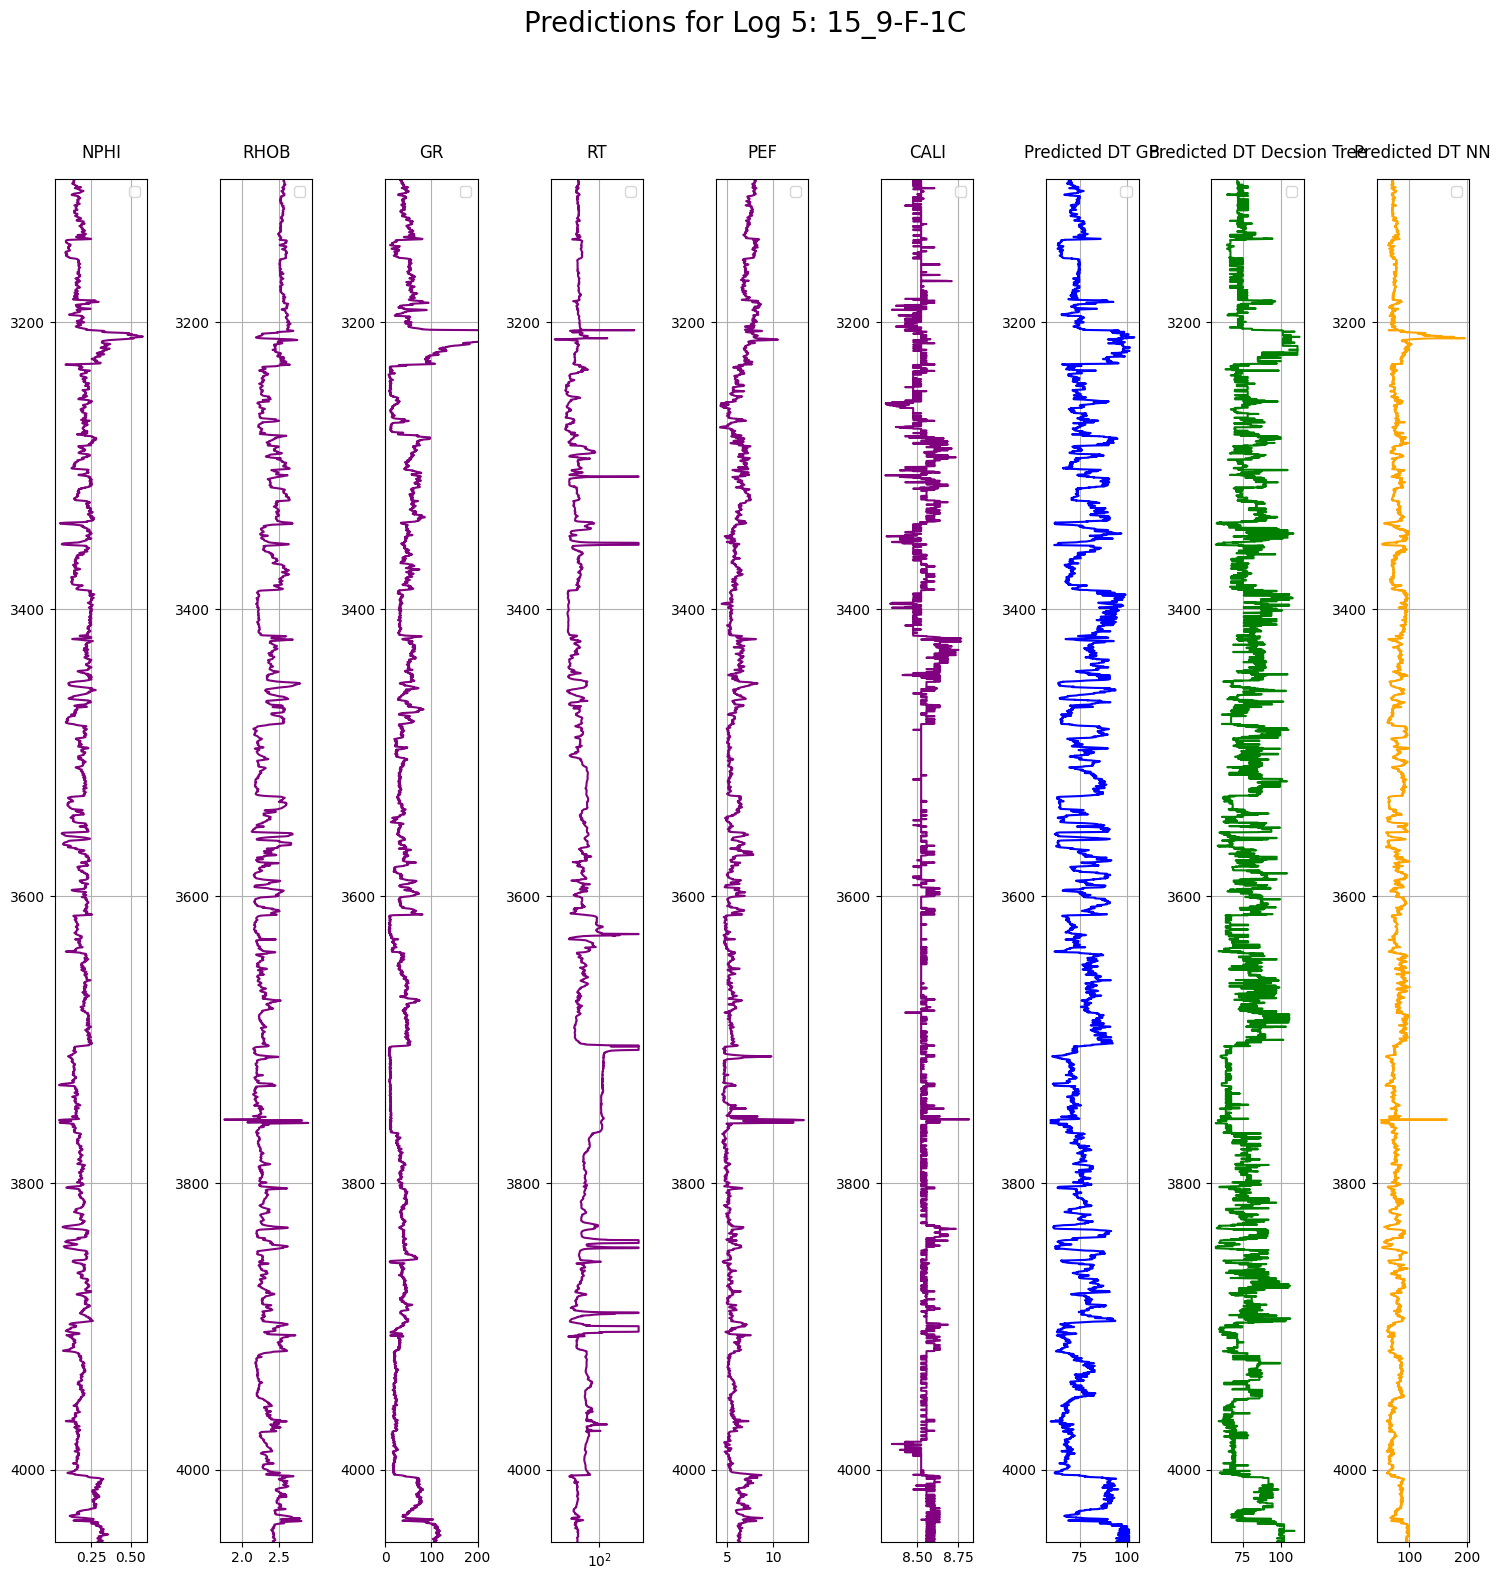

In [36]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue',  'green', 'orange'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")